## Instructions
Start with an arrival rate of 0.8 and a service rate of 1. <br>
#### First experiment: 100 trials <br>
 1. To compute empirical estimates in this simulation, you should run the simulation for at least 100 units of time. This is needed to make sure the simulation is in its equilibrium state. ** “Equilibrium state” essentially means you reach a state where the initial conditions of the simulation don't matter anymore and the same average behavior is observed for the rest of the time. **
 2. After 100 units of time, record the queue length at that point in time.
 3. Repeat the process above 100 times. This will give you 100 measurements of the queue length in the simulation. These are the results of your experiment.
 4. Plot a histogram of the results to visualize the distribution over the queue length.
 5. Compute an empirical estimate of the mean queue length for this M/D/1 queue with arrival rate 0.8 and service rate 1, including a 95% confidence interval of the mean.
#### Second experiment: 1000 trials <br>
 1. Now, repeat the experiment, but with 1000 trials (repetitions of the simulation) rather than 100 trials. Plot a histogram of the results and compute the average queue length and its confidence interval.
#### Compare the results from the two experiments. Comment on the following. <br>
+ Whether and how the distribution (histogram) over queue length changed.
+ Whether and how the average queue length estimate changed.
+ Whether and how the confidence interval of the average queue length changed.
#### Next, repeat the experiment but for different values of the arrival rate.<br>
1. Make an error plot of the average queue length and its 95% confidence interval for different values of the arrival rate and determine when the average queue length exceeds 5 people.

In [6]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [7]:
# M/D/1 queue

import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class BusSystem:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    bus_system = BusSystem(arrival_rate, service_rate)
    bus_system.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return bus_system

In [71]:
import matplotlib.pyplot as plt
import math
import numpy as np

def get_stats(data):
    
    m = np.mean(data)
    z = 1.96 #z-score
    
    s = np.std(data, ddof=1)
    n = len(data) 
    t = s/math.sqrt(n) #standard error
    
    return {"mean":m, "ci":[m-z*t, m+z*t]}


def create_error_plot(x,y,y_error):
    plt.figure()
    plt.errorbar(x, y, y_error,
                color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
    plt.xlabel("Arrival Rates")
    plt.ylabel("Mean queue length with 95% Confidence Interval")
    txt= (f"Fig A. "
            f"The plot shows how the queue length changes with the arrival rate.\n"
            f"The error bars show the 95% confidence interval of each value. \n"
            f"Each queue length is an average of 100 simulations, each running for 100 time units.")
    plt.figtext(0.5,-0.31, txt, horizontalalignment='center', fontsize=12)
    plt.show()

def plot_changing_arrivals(num_plot_points, arrival_rate_min, arrival_rate_max,
                  service_rate=1, run_length=100, trials=100):
    
    timestep = (arrival_rate_max - arrival_rate_min)/num_plot_points
    x = np.arange(arrival_rate_min, arrival_rate_max, timestep)
    y = [0 for _ in x]
    y_error = [0 for _ in x]
    for index, arrival_rate in enumerate(x):
        queue_storage = [0 for _ in range(trials)]
        for i in range(trials):
            bus_system = run_simulation(arrival_rate, service_rate, run_length)
            queue_storage[i] = bus_system.queue.people_in_queue
        stats = get_stats(queue_storage)
        y[index] = stats["mean"]
        y_error[index] = abs((stats["ci"][1]-stats["ci"][0])/2)
    create_error_plot(x,y,y_error)
    

def create_histogram(data, index, trial_num):
    plt.figure()
    #  plt.xkcd() # xkcd filter to show uncertainity
    plt.hist(data, bins=5, color="black") # Make a histogram
    stats = get_stats(data)
    mean = stats["mean"]
    c_lowerb = round(stats["ci"][0],3)
    c_upperb = round(stats["ci"][1],3)
    plt.xlabel('People in Queue')
    plt.ylabel('Number of simulation')
    txt= (f"Fig {index+1}. "
            f"Distribution of people remaining in bus queue \n after running "
            f"{trial_num} simulations. The average queue length is {mean} people.\n"
            f"The 95% Confidence interval is between {c_lowerb} and {c_upperb}. "
            f"This means that \n if we were to repeat the experiment 100 times, "
            f"the population mean \n would fall within {c_lowerb} and {c_upperb} people in queue on 95 ocassions.")
    plt.figtext(0.5,-0.31, txt, horizontalalignment='center', fontsize=12)
    plt.show()
    

def analyze(arrival_rate, service_rate, run_length, *args):
    for index, trials in enumerate(args):
        queue_storage = [0 for _ in range(trials)]
        for i in range(trials):
            bus_system = run_simulation(arrival_rate, service_rate, run_length)
            queue_storage[i] = bus_system.queue.people_in_queue   
        create_histogram(queue_storage, index, trials)
        


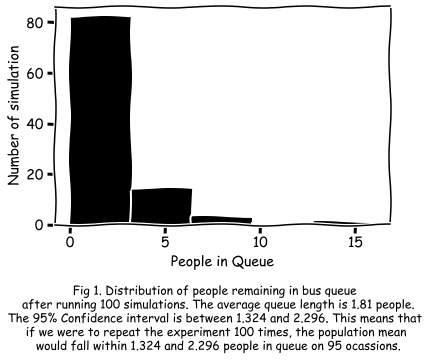

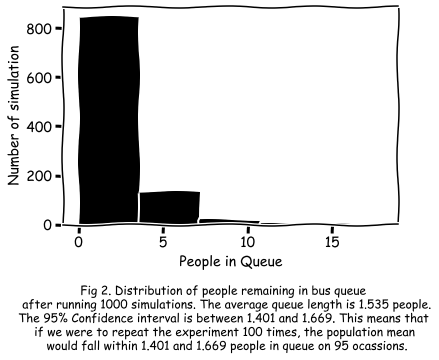

In [59]:
# Analysing with arrival rate 0.8, queue length 1, run_until = 100, trial numbers 100 and 1000 
analyze(0.8,1,100,100,1000)

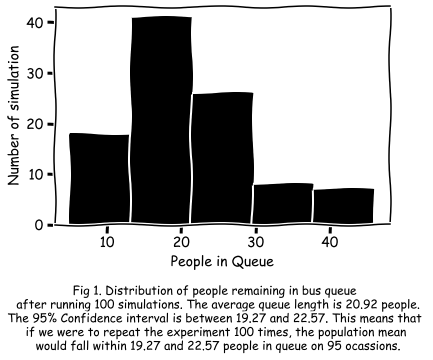

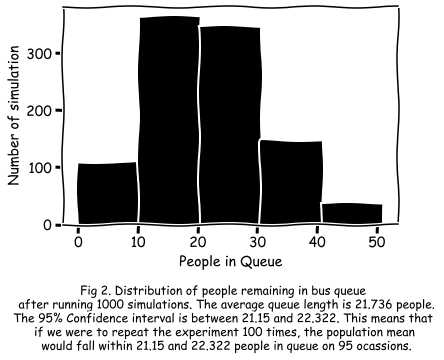

In [49]:
analyze(1,0.8,100,100,1000)

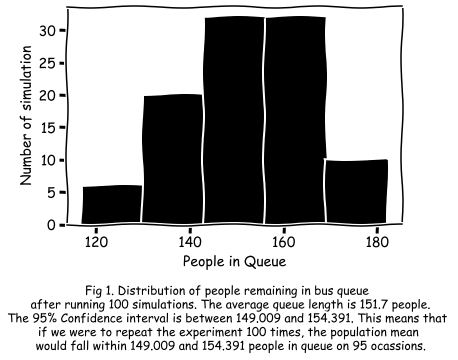

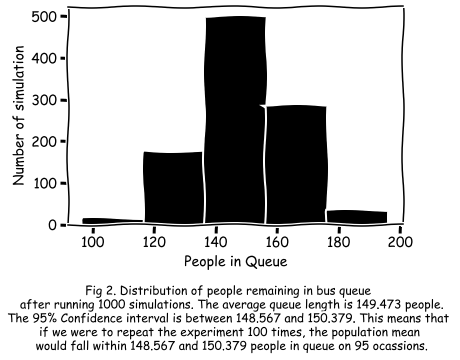

In [51]:
analyze(2,0.5,100,100,1000) #service time double

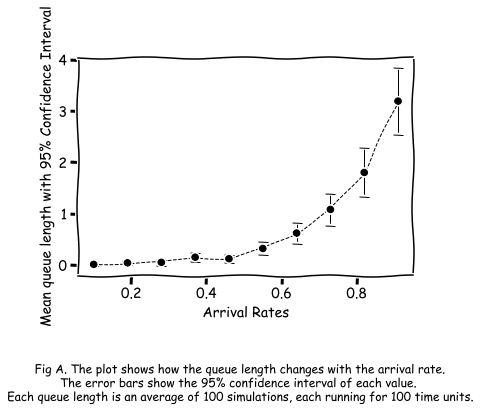

In [72]:
plot_changing_arrivals(10,0.1,1)

### Reflection 1
1. Whether and how the distribution (histogram) over queue length changed.
As the queue length increased and there were more samples to collect, the tail of the distributions got smaller relative to the middle of the distribution.
2. Whether and how the average queue length estimate changed.
The average queue increased as we increased the arrival rate (thus making the time people take to arrive shorter.) But there was no pattern in increasing the number of simulations (sometimes the mean went up, other times it went down as you increased the simulations).
3. Whether and how the confidence interval of the average queue length change.
The confidence interval was shortened as the number of samples collected increased. The reason is in how we calculate the confidence interval (specifically, the standard error). When we increase the same size the standard error becomes smaller as we divide the standard deviation by the square root of the sample size. Because we add or subtract the standard error from the sample mean, a smaller standard error would lead to a tighter interval.

### Reflection 2

1. Empirical Analysis
The results from the simulations were interpreted in the context of the problem. Specifically, how the confidence intervals related to the queue length. However, I would need to include further tests or a way to prove whether the model itself is running correctly. The simulation was run sufficient times.

2. Professionalism
The products were presented professionally. Although the figures had the xkcd filters on them, the class reading talked about using these filters as a way to convey uncertainty. Of course, you wouldn't give out these figures in a government report, however it might be helpful to create these figures to a wider audience (as if saying, look, the model is just a model that is assuming people are arriving at the same rate the 24 hrs. The model is not asking to be formalized.) There was no report, or mathematical notation and the python notebook needs additional work (refactoring, commenting, restructing, adding headers). Howeber, there are figure captions and axis labels.